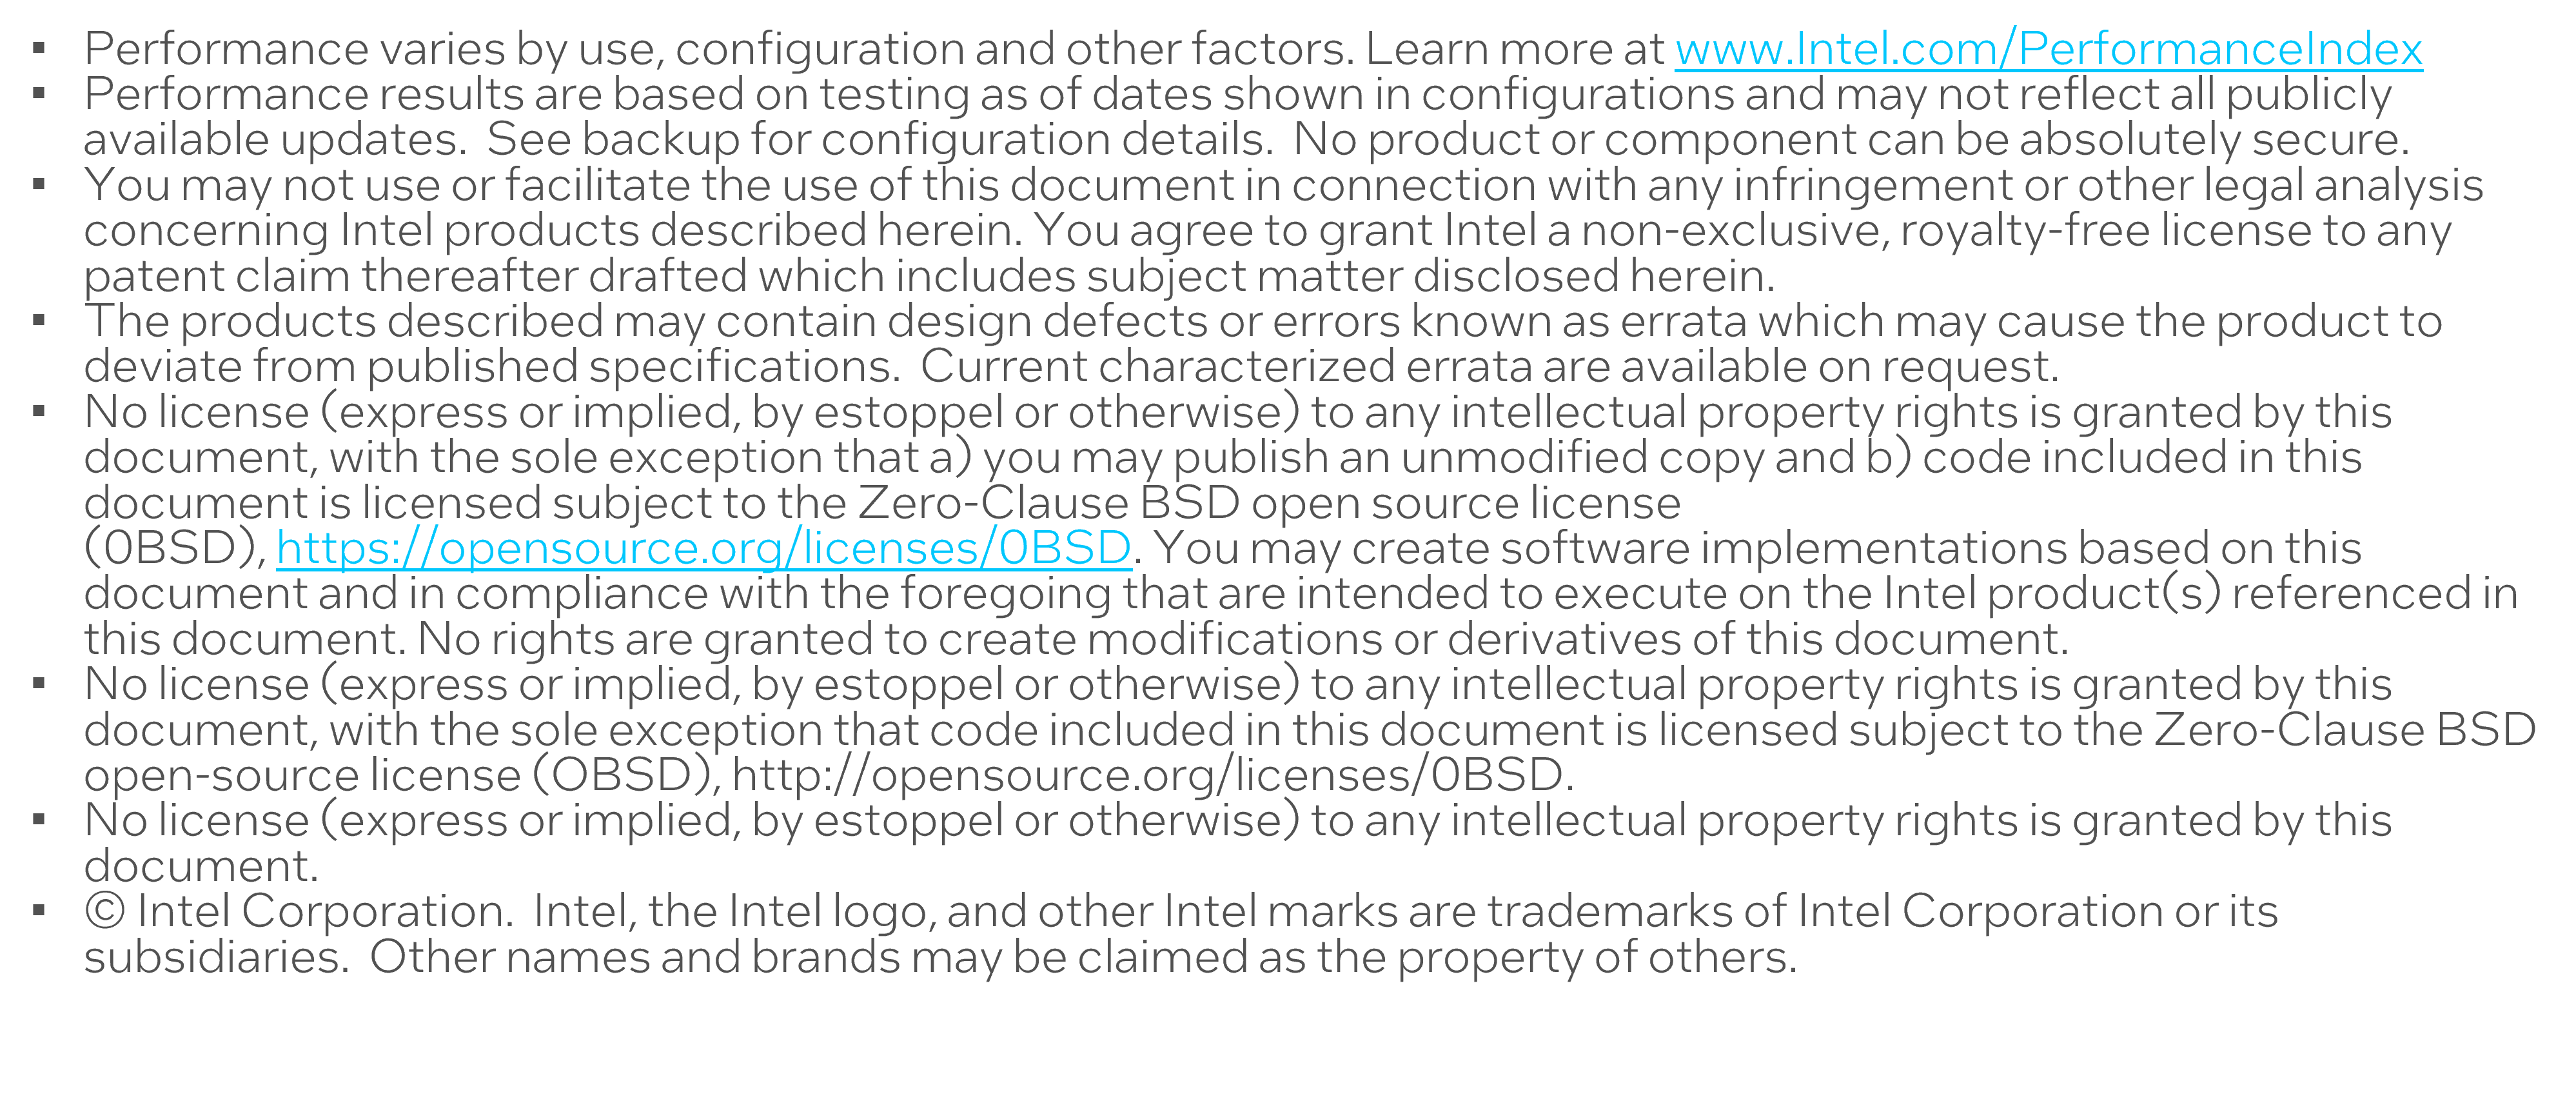

## Stable Diffusion on SPR with IPEX

This is a demo of [Stable Diffusion with the Hugging Face API](https://huggingface.co/stabilityai), and using the [Intel Extension for PyTorch](https://github.com/intel/intel-extension-for-pytorch) (IPEX) to optimize the model pipeline on Intel's 4th generation Xeon platform.

The demo consists of the following steps:

1. Load and define the core SD model components from HF.
2. Set up and run a standard SD pipeline with the HF API, i.e., generate a FP32 precision image.
3. Optimize SD with IPEX, using Auto Mixed Precision (BF16), and run the pipeline again.
4. Compare the results wrt inference latency time.
5. Run batched inference with the optimized SD pipeline.


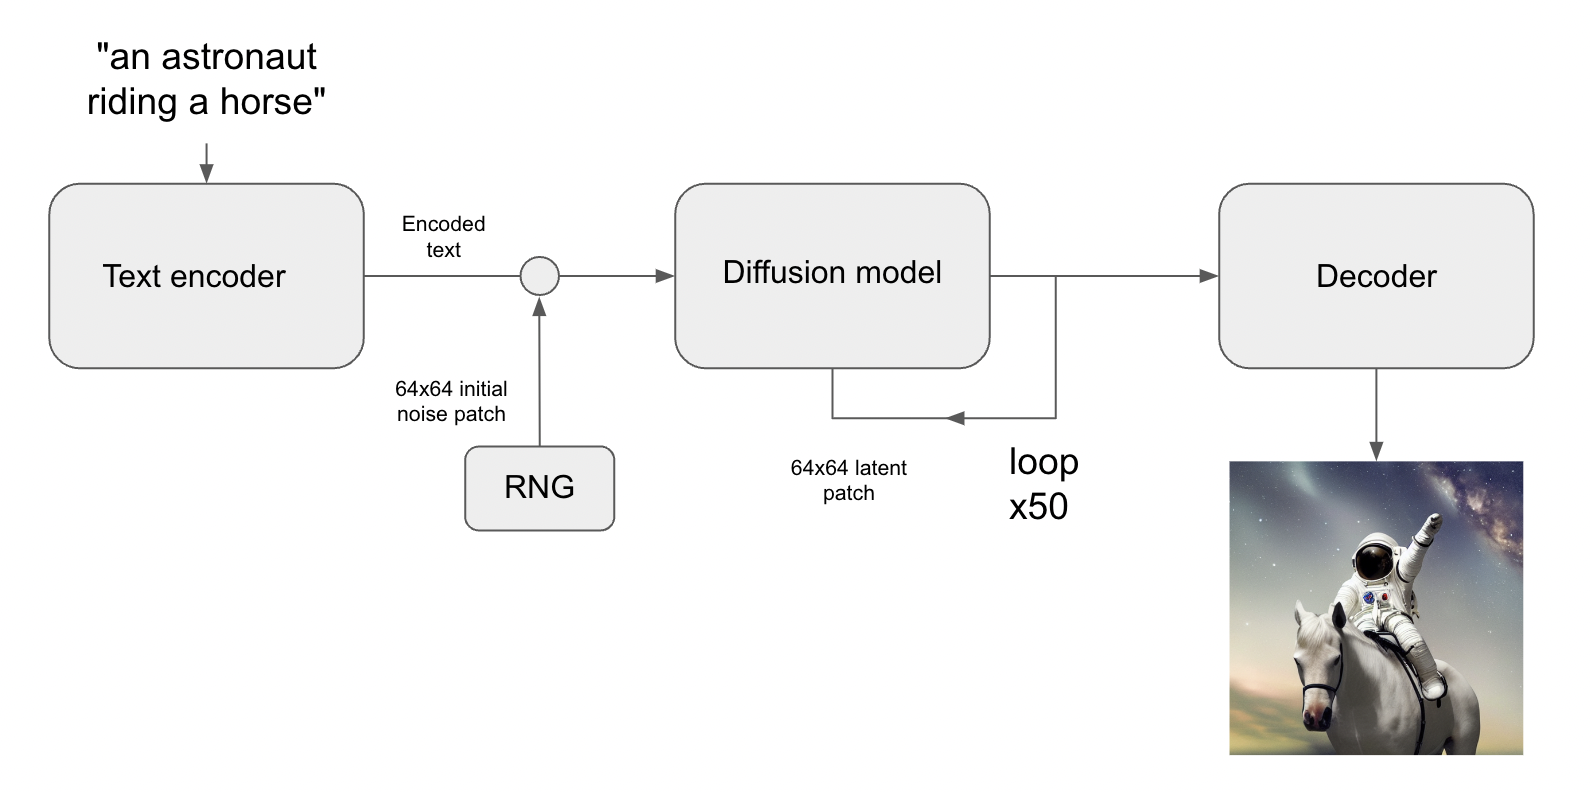

**This demo is executed in a Conda\* environment.**

The environment is the latest [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/ai-analytics-toolkit.html) PyTorch* environment, which includes Intel® Optimizations for deep learning workflows. See [here](https://software.intel.com/content/www/us/en/develop/articles/installing-ai-kit-with-conda.html) for more installation information.

If not yet installed, please make sure to uncomment the following line in order to install Diffusers, Transformers, and update Torch and IPEX.

In [1]:
# ! pip install -U diffusers transformers torch intel_extension_for_pytorch matplotlib

In [2]:
import torch

from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DPMSolverMultistepScheduler, EulerDiscreteScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import matplotlib.pyplot as plt

import time

/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Also, we need to register the usage of SD with our personal HF API token. Please paste your token either directly in the cell, or load it from a file. 

In [3]:
# My token
# MY_TOKEN = 'my_hf_api_token'
with open('hf_api.txt') as f:
    MY_TOKEN=f.read()

Please uncomment the following line if verbose oneDNN logging is wanted.

In [4]:
# %env ONEDNN_VERBOSE=1

Next, we load the various pretrained SD model core components from the HF hub:
- The CLIP text tokenizer.
- The CLIP text encoder.
- The UNET.
- And the Autoencoder.

In [5]:
# Define model ID for SD version
model_id = "CompVis/stable-diffusion-v1-4"
# model_id = "stabilityai/stable-diffusion-2-1"

# Load models and create wrapper for stable diffusion
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer", use_auth_token=MY_TOKEN)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", use_auth_token=MY_TOKEN)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", use_auth_token=MY_TOKEN)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", use_auth_token=MY_TOKEN)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Next, we construct the SD pipeline with the HF API. For different performances, experiment, e.g., with the scheduler, and its parameters.

In [6]:
scheduler=PNDMScheduler(beta_start=0.00085, 
                        beta_end=0.012, 
                        beta_schedule="scaled_linear", 
                        skip_prk_steps=True, 
                        steps_offset=1)
# scheduler=DPMSolverMultistepScheduler.from_config(scheduler.config)
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))

pipeline.safety_checker = lambda images, clip_input: (images, False)


/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


**Single image inference**

Then, we call the pipeline with a written description of the wanted image, i.e., the text prompt. And generate an image.

The inference process can be made deterministic by setting the generator seed. Furthermore, through the number of inference steps, we can govern the quality of the image, i.e., more steps equals better quality. Reduce the number of steps to receive results faster.

Please experiment with your own prompts!

In [7]:
# Define the prompt for the image generation
prompt = "Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"

# Set the number of iterations for the image generation
n_inf_steps = 20

# # Setting seed for deterministic output
# seed = 701
# generator = torch.Generator("cpu").manual_seed(seed)

# Simple timing of inference
start = time.time()
# image = pipeline(prompt, num_inference_steps=n_inf_steps, generator=generator).images[0]
image = pipeline(prompt, num_inference_steps=n_inf_steps).images[0]
end = time.time()
sd_fp32_t = end-start
print(f"Generating one FP32 image took {round(sd_fp32_t, 2)}s")

image.save("frog_test_FP32.png")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Generating one FP32 image took 24.17s


In [8]:
import intel_extension_for_pytorch as ipex

# Define model ID for SD version
model_id = "CompVis/stable-diffusion-v1-4"
# model_id = "stabilityai/stable-diffusion-2-1"

# Load models and create wrapper for stable diffusion
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer", use_auth_token=MY_TOKEN)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", use_auth_token=MY_TOKEN)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", use_auth_token=MY_TOKEN)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", use_auth_token=MY_TOKEN)


[W OperatorEntry.cpp:150] Warning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: torchvision::nms
    no debug info
  dispatch key: CPU
  previous kernel: registered at /build/intel-pytorch-extension/csrc/cpu/aten/TorchVisionNms.cpp:47
       new kernel: registered at /opt/workspace/vision/torchvision/csrc/ops/cpu/nms_kernel.cpp:112 (function registerKernel)
/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found

In [9]:
# Put model in eval mode.
unet.eval()

# unet to device=xpu
unet = unet.to('xpu')

# Optimize the model w/ IPEX
unet = ipex.optimize(unet)


/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:447: UserWarning: For XPU device, the split master weight is unsupported for now, so temp to disable it
  warnings.warn("For XPU device, the split master weight is unsupported for now, so temp to disable it")
/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:457: UserWarning: For XPU device to save valuable device memory, temp to do optimization on inplaced model, so                     make inplace to be true
  warnings.warn(
/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:464: UserWarning: For XPU, the weight prepack and sample input are disabled. The onednn layout                     is automatically chosen to use
  warnings.warn(
/home/gta/miniconda3/envs/stable_d/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:486: UserWarning: Conv BatchNorm folding fai

In [ ]:
scheduler=PNDMScheduler(beta_start=0.00085, 
                        beta_end=0.012, 
                        beta_schedule="scaled_linear", 
                        skip_prk_steps=True, 
                        steps_offset=1)
# scheduler=DPMSolverMultistepScheduler.from_config(scheduler.config)
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))

pipeline.safety_checker = lambda images, clip_input: (images, False)

pipeline = pipeline.to('xpu')



In [ ]:
# Define the prompt for the image generation
prompt = "Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"
# prompt = "Painting of a person with hat on a bicycle cycling in New York City"

# Set the number of iterations for the image generation
n_inf_steps = 50

# # Setting seed for deterministic output
seed = 701
generator = torch.Generator("cpu").manual_seed(seed)

# Simple timing of inference
start = time.time()
image = pipeline(prompt, num_inference_steps=n_inf_steps, generator=generator).images[0]
# image = pipeline(prompt, num_inference_steps=n_inf_steps).images[0]
end = time.time()
sd_pvc_fp32_t = end-start
print(f"Generating one FP32 image took {round(sd_fp32_t, 2)}s")

image.save("frog_test_FP32_pvc.png")

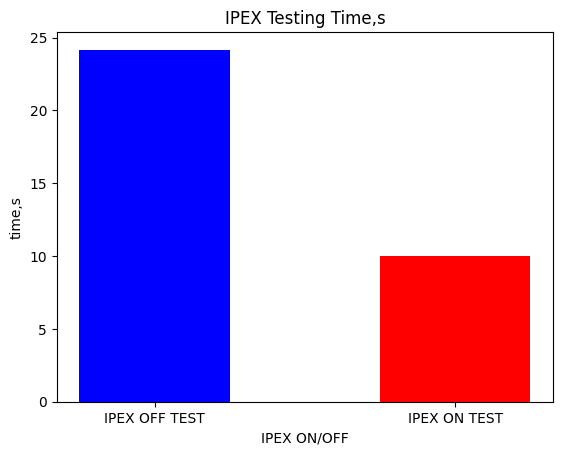

Performance Speedup Testing:  2.41469726358367


In [24]:
#show performance boost

pred_times = [sd_fp32_t, sd_pvc_fp32_t]
tick_label = ['IPEX OFF TEST', 'IPEX ON TEST']

left = [1,2]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
plt.xlabel('IPEX ON/OFF'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()

print("Performance Speedup Testing: ",(sd_fp32_t)/(sd_pvc_fp32_t))

Pipeline of SD: The UNET component of the model architecture is the one that uses most computational resources in the inference process.

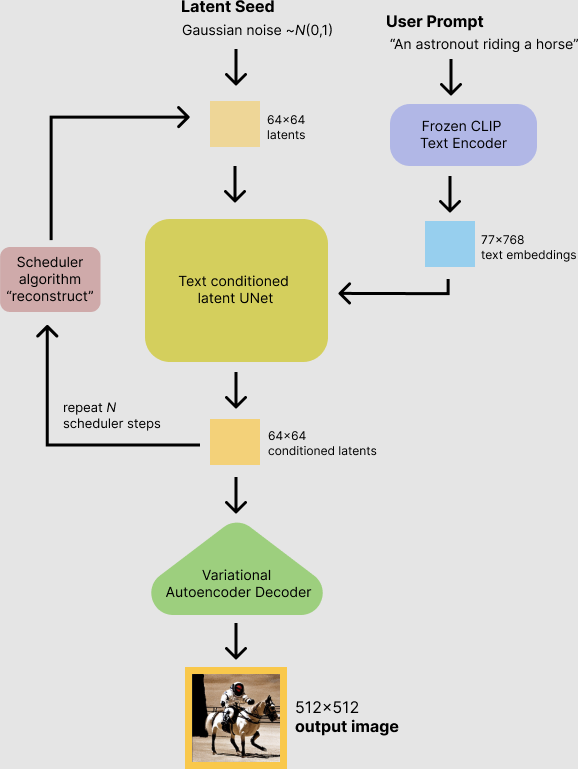

**Optimization with IPEX**

The UNET component of the model architecture is the one that uses most computational resources in the inference process. Hence, with IPEX, we optimize it, and put it in BF16 precision.
Please note: Experiment also with the optimization of the text encoder.

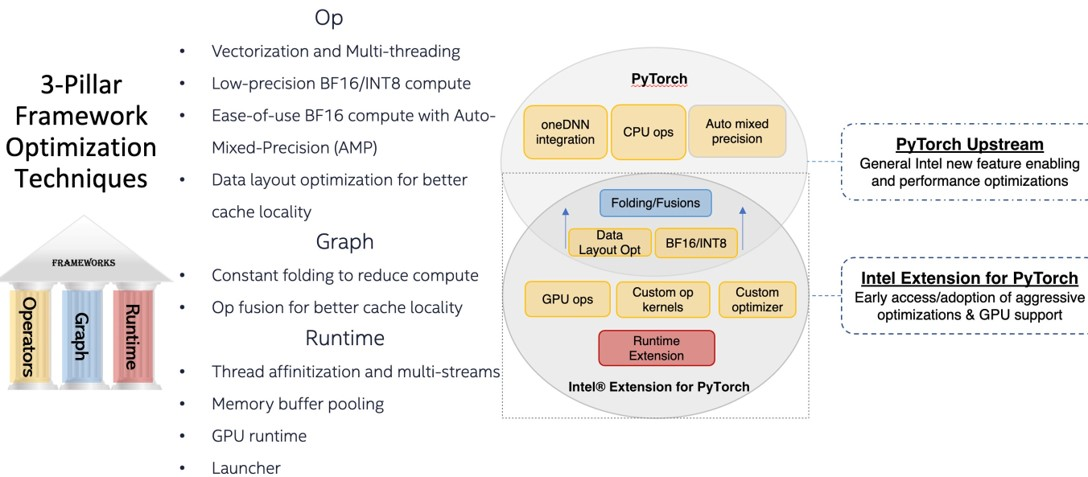